In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA data mixing ablation")
Viking_7B_Flores_200_De_En_BLEU = spreadsheet.worksheet("Viking-7B-Flores-200-De-En-BLEU")

In [12]:
Viking_7B_Flores_200_De_En_BLEU_Data = Viking_7B_Flores_200_De_En_BLEU.get_all_records(value_render_option="UNFORMATTED_VALUE")
df = pd.DataFrame(Viking_7B_Flores_200_De_En_BLEU_Data, columns=Viking_7B_Flores_200_De_En_BLEU_Data[0])
df = df.replace('', np.nan)

/tmp/ipykernel_3892036/1709479095.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


In [13]:
df

,Model,checkpoint-500,checkpoint-1000,checkpoint-1500,checkpoint-2000,checkpoint-2500,checkpoint-3000,checkpoint-3500,checkpoint-4000,checkpoint-4500
0,Viking-7B-Bilingual-Code-Selfish,3.414304,13.953946,15.447039,14.912711,14.044737,15.832836,14.658420,15.901047,16.69336
1,Viking-7B-Bilingual-Selfish,7.825826,10.601172,10.820943,14.906967,10.700561,12.284887,11.460643,11.150980,NaN
2,Viking-7B-Monolingual-Code-Selfish,10.050142,6.788320,8.897974,8.557510,8.362883,9.796742,10.425957,12.222515,NaN
3,Viking-7B-Monolingual-Selfish,8.046509,4.642167,6.077979,6.361425,5.928028,6.294357,6.091497,NaN,NaN


In [14]:
model_info = {
    "Viking-7B-Bilingual-Code-Selfish": {
        "final_ckpt": 4500,
        "total_tokens": 300e6,  # 300M
    },
    "Viking-7B-Monolingual-Code-Selfish": {
        "final_ckpt": 4000,
        "total_tokens": 300e6,  # 300M
    },
    "Viking-7B-Bilingual-Selfish": {
        "final_ckpt": 4000, 
        "total_tokens": 200e6   # 200M
    },  
    "Viking-7B-Monolingual-Selfish": {
        "final_ckpt": 3500,
        "total_tokens": 200e6,  # 200M
    },
}


def ckpt_to_tokens(model_name: str, ckpt: int) -> float:
    """
    Given model name and checkpoint numbers, return the corresponding number of trained tokens.
    """
    info = model_info[model_name]
    final_ckpt = info["final_ckpt"]
    total_tokens = info["total_tokens"]
    if ckpt > final_ckpt:
        ckpt = final_ckpt

    return ckpt * (total_tokens / final_ckpt)

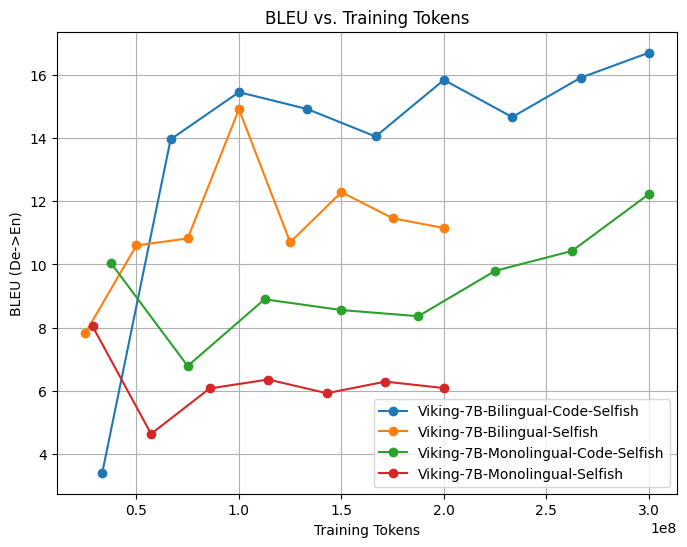

In [ ]:
checkpoint_cols = [col for col in df.columns if col.startswith("checkpoint-")]

plt.figure(figsize=(8, 6))

for i, row in df.iterrows():
    model_name = row["Model"]
    if model_name not in model_info:
        continue

    ckpt_bleu_pairs = []
    for col in checkpoint_cols:
        val = row[col]
        if pd.notna(val):
            ckpt = int(col.split("-")[1])
            x_tokens = ckpt_to_tokens(model_name, ckpt)
            y_bleu = float(val)
            ckpt_bleu_pairs.append((x_tokens, y_bleu))

    ckpt_bleu_pairs.sort(key=lambda x: x[0])

    xs = [p[0] for p in ckpt_bleu_pairs]
    ys = [p[1] for p in ckpt_bleu_pairs]

    plt.plot(xs, ys, marker="o", label=model_name)

plt.xlabel("Training Tokens")
plt.ylabel("BLEU (De->En)")
plt.title("BLEU vs. Training Tokens")
plt.legend()
plt.grid(True)
plt.show()

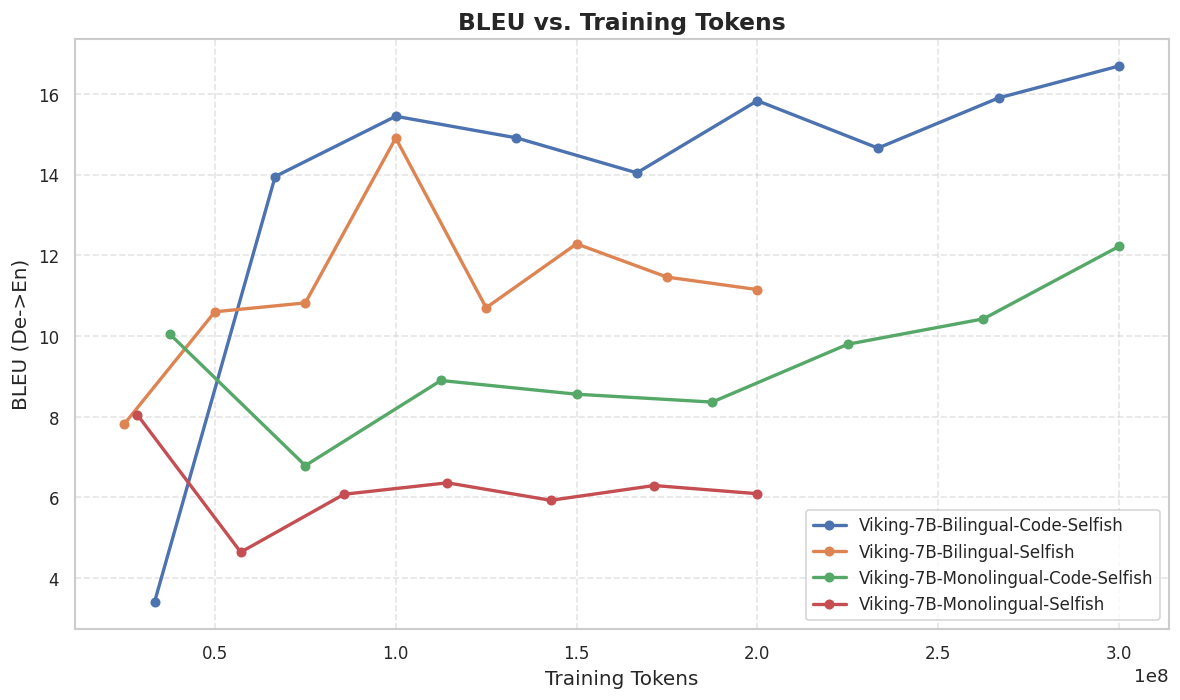

In [ ]:
sns.set_theme(style="whitegrid")  
# plt.style.use("ggplot")  # "seaborn", "bmh", "classic" 等等

checkpoint_cols = [col for col in df.columns if col.startswith("checkpoint-")]

plt.figure(figsize=(10, 6), dpi=120)  

for i, row in df.iterrows():
    model_name = row["Model"]
    if model_name not in model_info:
        continue

    ckpt_bleu_pairs = []
    for col in checkpoint_cols:
        val = row[col]
        if pd.notna(val) and val != "":
            ckpt = int(col.split("-")[1])
            x_tokens = ckpt_to_tokens(model_name, ckpt)
            y_bleu = float(val)
            ckpt_bleu_pairs.append((x_tokens, y_bleu))

    ckpt_bleu_pairs.sort(key=lambda x: x[0])

    xs = [p[0] for p in ckpt_bleu_pairs]
    ys = [p[1] for p in ckpt_bleu_pairs]

    plt.plot(xs, ys,
             marker="o",
             linestyle="-",   # 线型
             linewidth=2,     # 线宽
             markersize=5,    # 点的大小
             label=model_name)

plt.xlabel("Training Tokens", fontsize=12)
plt.ylabel("BLEU (De->En)", fontsize=12)
plt.title("BLEU vs. Training Tokens", fontsize=14, fontweight="bold")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)  # alpha 控制网格透明度
plt.legend(loc="best", fontsize=10)        # loc="upper left"/"upper right"/"best" 等
plt.tight_layout()                         # 自动调节子图间的空隙

# 7. 显示图表
plt.show()